# VGG-16 Finetuning & Training

This notebook details the steps involved in fine-tuning a pre-trained VGG16 model for tumor image classification. The aim is to leverage the existing knowledge of a pre-trained model to improve performance and reduce training time on our specific task: identifying different types of tumors.

The process begins by loading the pre-trained VGG16 model and adjusting the last fully connected layer to match the number of tumor classes we aim to classify. We then train this adapted model on our tumor image dataset, specifically tracking the loss and accuracy metrics during the process to assess the performance of our model.

The pretrained model can be obtained from https://huggingface.co/timm/vgg16.tv_in1k

The next code snippet showcases how you can load the pretrained VGG-16 model to classify images.

tensor([[27.1887, 19.0882,  6.0838,  5.7336,  4.6251]], device='cuda:0',
       grad_fn=<TopkBackward0>)
ice_cream: 27.19%
trifle: 19.09%
espresso: 6.08%
chocolate_sauce: 5.73%
bagel: 4.63%


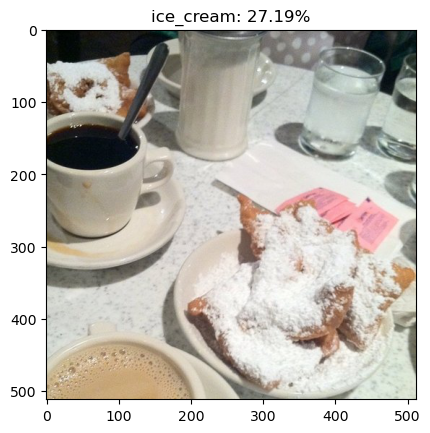

In [4]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json
import urllib.request
from torchvision import models, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model_path = "vgg16.tv_in1k/pytorch_model.bin"#"../vgg19.tv_in1k/pytorch_model.bin"
state_dict = torch.load(model_path, map_location=torch.device('cpu'))#timm.create_model('vgg19', pretrained=True)

model = timm.create_model('vgg16', pretrained=False)
model.load_state_dict(state_dict)

model.to(device)

model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0).to(device))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
print(top5_probabilities)


# Load the ImageNet class index
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(url).read().decode())

# Get the top 5 class indices and probabilities
top5_class_indices = top5_class_indices.squeeze().tolist()
top5_probabilities = top5_probabilities.squeeze().tolist()

# Print the top 5 class labels and probabilities
for i in range(5):
    class_index_str = class_index[str(top5_class_indices[i])]
    class_label = class_index_str[1]
    print(f"{class_label}: {top5_probabilities[i]:.2f}%")

plt.imshow(img)
plt.title(f"{class_index[str(top5_class_indices[0])][1]}: {top5_probabilities[0]:.2f}%")
plt.show()

# Data Loading

In this part of the notebook, we define a custom convolutional neural network (CNN) and load our dataset.

The SimpleCNN class defines a small, custom CNN that we can use to compare the performance of our fine-tuned VGG16 model. The structure of SimpleCNN includes two convolutional layers, each followed by a ReLU activation function and max pooling. This is then followed by three fully-connected layers, with the final layer being the output layer, having as many neurons as the number of classes we have in our problem.

After defining our model, we specify the computing device (GPU or CPU) and load our training and validation datasets using the helper functions from ImageFolderDataset. The ImageFolderDataset allows you to specify how many classes you want to include in the classifier. We also print out some basic statistics about these datasets, such as the number of samples in each set and the classes they contain. This step is crucial as it allows us to ensure our data is correctly loaded and understand the dataset better before proceeding to model training and evaluation.

In [1]:
from finetuning.ImageFolderDataset import ImageFolderDataset
from finetuning.ImageFolderDataset import loadAndPrepareData, countSamplesPerClass
from finetuning.TumorClassifier import TumorClassifier
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels, 16 output channels, 5x5 kernel
        # the number of input features to the first fully connected layer depends on the size of your input image.
        # Given the pooling and convolutional layers above and an input image size of 512x512, it would be 16*125*125
        self.fc1 = nn.Linear(16 * 125 * 125, 120)  # input features, output features
        self.fc2 = nn.Linear(120, 84)  # input features, output features
        self.fc3 = nn.Linear(84, num_classes)  # input features, output features

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # apply conv1, ReLU, then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # apply conv2, ReLU, then max pooling
        x = x.view(-1, 16 * 125 * 125)  # flatten the tensor
        x = F.relu(self.fc1(x))  # apply fc1 and ReLU
        x = F.relu(self.fc2(x))  # apply fc2 and ReLU
        x = self.fc3(x)  # apply fc3
        x = F.softmax(x, dim=1)  # apply softmax to output
        return x
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# -------- DATA -------- #

root_dir = '../resized/512x512/'
train_loader, val_loader, dataset = loadAndPrepareData(root_dir, batch_size=4, n_classes=127)

print("==== Training Dataset ====")
print(f"Number of samples: {len(train_loader.dataset)}")
#print(f"Samples per class: {countSamplesPerClass(train_loader)}")

print("==== Validation Dataset ====")
print(f"Number of samples: {len(val_loader.dataset)}")
#print(f"Samples per class: {countSamplesPerClass(val_loader)}")

print(f"\nNumber of classes: {len(set(dataset.labels))}")
print(f"Classes: {set(dataset.classes)}")

print(dataset.classes)

img, labels = next(iter(train_loader))
print(img.shape)
print(labels)

Counter({56: 474, 104: 173, 85: 104, 110: 99, 6: 91, 50: 88, 59: 88, 0: 85, 93: 85, 13: 83, 117: 81, 30: 70, 125: 68, 32: 59, 57: 59, 47: 57, 3: 50, 1: 47, 2: 47, 27: 47, 87: 47, 5: 46, 40: 46, 118: 41, 71: 38, 55: 34, 61: 34, 68: 32, 78: 32, 9: 31, 60: 30, 21: 28, 113: 28, 15: 25, 35: 25, 105: 24, 121: 24, 88: 23, 90: 23, 18: 21, 24: 21, 34: 21, 54: 21, 111: 21, 16: 20, 53: 20, 31: 19, 14: 17, 102: 17, 91: 16, 75: 15, 120: 14, 25: 13, 73: 13, 97: 13, 20: 12, 29: 11, 101: 11, 116: 11, 92: 10, 80: 9, 95: 9, 96: 8, 11: 7, 23: 7, 63: 7, 81: 7, 41: 6, 52: 6, 77: 6, 106: 6, 108: 6, 4: 5, 64: 5, 76: 5, 83: 5, 89: 5, 107: 5, 114: 5, 12: 4, 17: 4, 19: 4, 44: 4, 70: 4, 86: 4, 8: 3, 39: 3, 48: 3, 62: 3, 79: 3, 82: 3, 100: 3, 109: 3, 115: 3, 10: 2, 46: 2, 51: 2, 66: 2, 74: 2, 84: 2, 98: 2, 99: 2, 7: 1, 22: 1, 26: 1, 28: 1, 33: 1, 36: 1, 37: 1, 38: 1, 42: 1, 43: 1, 45: 1, 49: 1, 58: 1, 65: 1, 67: 1, 69: 1, 72: 1, 94: 1, 103: 1, 112: 1, 119: 1, 122: 1, 123: 1, 124: 1, 126: 1})
==== Training Dataset

# Model loading

In [3]:
# -------- MODEL -------- #

# Imagenet pretrained vgg16 model
vgg16_imagenet_path = "../vgg16.tv_in1k/pytorch_model.bin"

# brain tumor trained vgg16 model
#model_path = "models/model_100.pt"

model = timm.create_model('vgg16', pretrained=False)

# load the pretrained model weights
state_dict = torch.load(vgg16_imagenet_path, map_location=torch.device('cpu'))#timm.create_model('vgg19', pretrained=True)
model.load_state_dict(state_dict)

# Output dimension, which is equal to the number of different tumour classes
output_dim = len(set(dataset.labels))


#model = SimpleCNN(output_dim)

# Replace the last fully connected layer to match the number of classes in the new data set
num_ftrs = model.head.fc.in_features
model.head.fc = nn.Linear(num_ftrs, output_dim)

# Add dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, output_dim)
)

#model.load_state_dict(state_dict)

#model.to(device)

In [ ]:
'''model.eval()

img, labels = next(iter(train_loader))

output = model(img)
print(output.shape)

# Compute the maximum predicted class and its corresponding output value
_, predicted_class = torch.max(output, 1)
output_max = output[0, predicted_class]

# Compute the gradient of output_max with respect to the parameters of the model
model.zero_grad()
output_max.backward()

# Compute the saliency map
saliency, _ = torch.max(model.conv1.weight.grad.abs(), dim=1)
saliency = saliency.reshape((3, 224, 224))

# Visualize the saliency map
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
plt.imshow(saliency.cpu().detach().numpy(), cmap='hot')
plt.show()'''

"model.eval()\n\nimg, labels = next(iter(train_loader))\n\noutput = model(img)\nprint(output.shape)\n\n# Compute the maximum predicted class and its corresponding output value\n_, predicted_class = torch.max(output, 1)\noutput_max = output[0, predicted_class]\n\n# Compute the gradient of output_max with respect to the parameters of the model\nmodel.zero_grad()\noutput_max.backward()\n\n# Compute the saliency map\nsaliency, _ = torch.max(model.conv1.weight.grad.abs(), dim=1)\nsaliency = saliency.reshape((3, 224, 224))\n\n# Visualize the saliency map\nsaliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())\nplt.imshow(saliency.cpu().detach().numpy(), cmap='hot')\nplt.show()"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


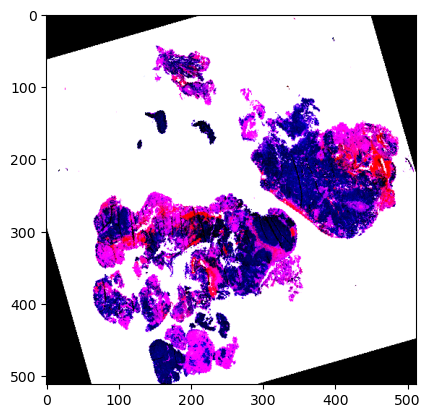

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


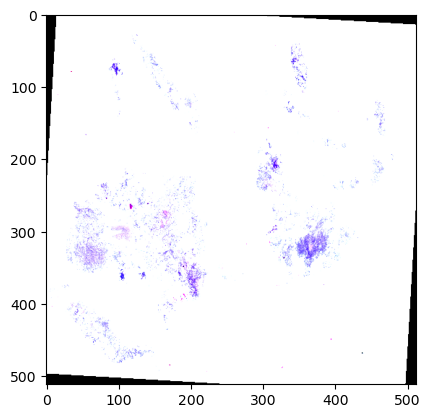

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


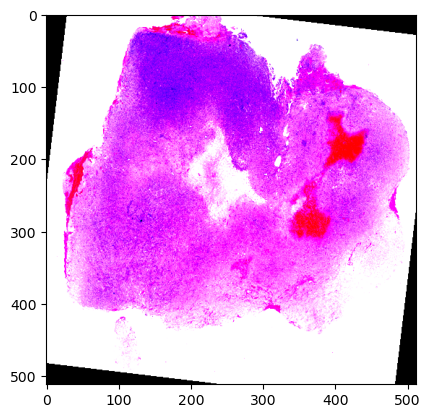

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


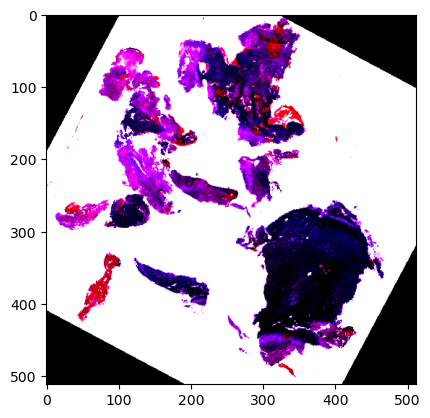

In [3]:
from matplotlib import pyplot as plt

for _img in img:
    plt.figure()
    plt.imshow(_img.permute(1, 2, 0))
    plt.show()

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean()

def calculate_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1)
    labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

def plot_confusion_matrix(outputs, labels):
    _, preds = torch.max(outputs, 1)
    labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
    cm = confusion_matrix(labels, preds)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    return fig

def get_incorrect_predictions(inputs, outputs, labels):
    _, preds = torch.max(outputs, 1)
    incorrect = (preds != labels)
    incorrect_images = inputs[incorrect]
    incorrect_labels = preds[incorrect]
    return incorrect_images, incorrect_labels

In [4]:
from torch.utils.tensorboard import SummaryWriter

import os
import math
from matplotlib import pyplot as plt
import numpy as np

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath):
    model = model_class()  # Initialize model
    model.load_state_dict(torch.load(filepath))
    return model

def add_histogram(writer, tag, values, bins=100, global_step=None):
    counts, bin_edges = np.histogram(values, bins=bins)

    # Required data for histogram
    bin_edges = bin_edges[1:]
    bin_counts = counts

    data = torch.Tensor([float(d) for d in bin_counts])
    bin_edges = torch.Tensor([float(d) for d in bin_edges])

    writer.add_histogram_raw(
        tag,
        min=values.min(),
        max=values.max(),
        num=len(values),
        sum=float(values.sum()),
        sum_squares=float((values ** 2).sum()),
        bucket_limits=bin_edges,
        bucket_counts=data,
        global_step=global_step,
    )

def train():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Initialize the learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=1.0/math.e)
    
    if not os.path.exists("runs"):
        os.mkdir("runs")
    train_run = len(os.listdir("runs")) + 1
    folder_path = f"runs/train_run_{train_run}"

    # Initialize the TensorBoard writer and write initial model weights
    writer = SummaryWriter(folder_path)
    add_histogram(writer, 'features.0/weights', model.features[0].weight.view(-1).detach().cpu())
    add_histogram(writer, 'features.2/weights', model.features[2].weight.view(-1).detach().cpu())

    num_epochs = 1000
    print('Starting training...')

    for epoch in range(num_epochs):
        
        # Initialize metrics
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running metrics
            running_loss += loss.item()

        # Average metrics and print them
        running_loss /= len(train_loader)

        # Log the metrics to TensorBoard
        writer.add_scalar('Train/Loss', running_loss, epoch)

        # Log the model weights
        add_histogram(writer, 'features.0/weights', model.features[0].weight.view(-1).detach().cpu(), global_step=epoch)
        add_histogram(writer, 'features.2/weights', model.features[2].weight.view(-1).detach().cpu(), global_step=epoch)

        if epoch % 20 == 0:
            evaluate(model, train_loader, writer, criterion, epoch, mode='Train', save_loss=False)
            evaluate(model, val_loader, writer, criterion, epoch, mode='Validation')

        if epoch % 100 == 0:
            save_model(model, f"{folder_path}/model_{epoch}.pt")

        print('Epoch %d: Training Loss: %.3f' % (epoch + 1, running_loss))
        
        # Step the learning rate scheduler
        scheduler.step()

    writer.close()

def evaluate(model, dataloader, writer, criterion, epoch, mode='val', save_loss=True):
    model.eval()

    running_loss = 0.0
    running_acc = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate accuracy and metrics
            acc = calculate_accuracy(outputs, labels)
            precision, recall, f1 = calculate_metrics(outputs, labels)

            # Update running metrics
            running_loss += loss.item()
            running_acc += acc.item()
            running_precision += precision
            running_recall += recall
            running_f1 += f1

        # Average metrics and print them
        running_loss /= len(dataloader)
        running_acc /= len(dataloader)
        running_precision /= len(dataloader)
        running_recall /= len(dataloader)
        running_f1 /= len(dataloader)

        # Log the metrics to TensorBoard
        if save_loss:
            writer.add_scalar(f'{mode}/Loss', running_loss, epoch)
        writer.add_scalar(f'{mode}/Accuracy', running_acc, epoch)
        writer.add_scalar(f'{mode}/Precision', running_precision, epoch)
        writer.add_scalar(f'{mode}/Recall', running_recall, epoch)
        writer.add_scalar(f'{mode}/F1 Score', running_f1, epoch)

    model.train()

    return running_loss

# Move to device
model = model.to(device)
train()
model = model.to('cpu')


Starting training...


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 1: Training Loss: 4.786
Epoch 2: Training Loss: 4.468
Epoch 3: Training Loss: 4.091
Epoch 4: Training Loss: 3.676
Epoch 5: Training Loss: 3.297
Epoch 6: Training Loss: 2.901
Epoch 7: Training Loss: 2.545
Epoch 8: Training Loss: 2.311
Epoch 9: Training Loss: 2.049
Epoch 10: Training Loss: 1.868
Epoch 11: Training Loss: 1.629
Epoch 12: Training Loss: 1.519
Epoch 13: Training Loss: 1.397
Epoch 14: Training Loss: 1.228
Epoch 15: Training Loss: 1.093
Epoch 16: Training Loss: 1.010
Epoch 17: Training Loss: 0.948
Epoch 18: Training Loss: 0.897
Epoch 19: Training Loss: 0.826
Epoch 20: Training Loss: 0.747


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 21: Training Loss: 0.702
Epoch 22: Training Loss: 0.624
Epoch 23: Training Loss: 0.613
Epoch 24: Training Loss: 0.573
Epoch 25: Training Loss: 0.578
Epoch 26: Training Loss: 0.319
Epoch 27: Training Loss: 0.272
Epoch 28: Training Loss: 0.220
Epoch 29: Training Loss: 0.233
Epoch 30: Training Loss: 0.246
Epoch 31: Training Loss: 0.214
Epoch 32: Training Loss: 0.160
Epoch 33: Training Loss: 0.179
Epoch 34: Training Loss: 0.174
Epoch 35: Training Loss: 0.155
Epoch 36: Training Loss: 0.140
Epoch 37: Training Loss: 0.145
Epoch 38: Training Loss: 0.148
Epoch 39: Training Loss: 0.123
Epoch 40: Training Loss: 0.101


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 41: Training Loss: 0.147
Epoch 42: Training Loss: 0.126
Epoch 43: Training Loss: 0.095
Epoch 44: Training Loss: 0.109
Epoch 45: Training Loss: 0.112
Epoch 46: Training Loss: 0.099
Epoch 47: Training Loss: 0.092
Epoch 48: Training Loss: 0.118
Epoch 49: Training Loss: 0.097
Epoch 50: Training Loss: 0.073
Epoch 51: Training Loss: 0.059
Epoch 52: Training Loss: 0.042
Epoch 53: Training Loss: 0.034
Epoch 54: Training Loss: 0.036
Epoch 55: Training Loss: 0.024
Epoch 56: Training Loss: 0.030
Epoch 57: Training Loss: 0.027
Epoch 58: Training Loss: 0.029
Epoch 59: Training Loss: 0.030
Epoch 60: Training Loss: 0.022


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 61: Training Loss: 0.029
Epoch 62: Training Loss: 0.023
Epoch 63: Training Loss: 0.028
Epoch 64: Training Loss: 0.029
Epoch 65: Training Loss: 0.029
Epoch 66: Training Loss: 0.024
Epoch 67: Training Loss: 0.019
Epoch 68: Training Loss: 0.018
Epoch 69: Training Loss: 0.018
Epoch 70: Training Loss: 0.018
Epoch 71: Training Loss: 0.019
Epoch 72: Training Loss: 0.019
Epoch 73: Training Loss: 0.007
Epoch 74: Training Loss: 0.013
Epoch 75: Training Loss: 0.034
Epoch 76: Training Loss: 0.015
Epoch 77: Training Loss: 0.007
Epoch 78: Training Loss: 0.010
Epoch 79: Training Loss: 0.010
Epoch 80: Training Loss: 0.007


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 81: Training Loss: 0.003
Epoch 82: Training Loss: 0.004
Epoch 83: Training Loss: 0.008
Epoch 84: Training Loss: 0.004
Epoch 85: Training Loss: 0.008
Epoch 86: Training Loss: 0.005
Epoch 87: Training Loss: 0.008
Epoch 88: Training Loss: 0.007
Epoch 89: Training Loss: 0.008
Epoch 90: Training Loss: 0.004
Epoch 91: Training Loss: 0.008
Epoch 92: Training Loss: 0.003
Epoch 93: Training Loss: 0.005
Epoch 94: Training Loss: 0.002
Epoch 95: Training Loss: 0.004
Epoch 96: Training Loss: 0.003
Epoch 97: Training Loss: 0.005
Epoch 98: Training Loss: 0.008
Epoch 99: Training Loss: 0.003
Epoch 100: Training Loss: 0.002


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 101: Training Loss: 0.001
Epoch 102: Training Loss: 0.001
Epoch 103: Training Loss: 0.003
Epoch 104: Training Loss: 0.002
Epoch 105: Training Loss: 0.003
Epoch 106: Training Loss: 0.001
Epoch 107: Training Loss: 0.003
Epoch 108: Training Loss: 0.002
Epoch 109: Training Loss: 0.002
Epoch 110: Training Loss: 0.002
Epoch 111: Training Loss: 0.009
Epoch 112: Training Loss: 0.002
Epoch 113: Training Loss: 0.001
Epoch 114: Training Loss: 0.001
Epoch 115: Training Loss: 0.001
Epoch 116: Training Loss: 0.001
Epoch 117: Training Loss: 0.001
Epoch 118: Training Loss: 0.001
Epoch 119: Training Loss: 0.000
Epoch 120: Training Loss: 0.000


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: Undefi

Epoch 121: Training Loss: 0.003
Epoch 122: Training Loss: 0.002
Epoch 123: Training Loss: 0.001
Epoch 124: Training Loss: 0.001
Epoch 125: Training Loss: 0.003
Epoch 126: Training Loss: 0.001
Epoch 127: Training Loss: 0.001
Epoch 128: Training Loss: 0.000
Epoch 129: Training Loss: 0.003
Epoch 130: Training Loss: 0.001
Epoch 131: Training Loss: 0.002
Epoch 132: Training Loss: 0.006
Epoch 133: Training Loss: 0.002
Epoch 134: Training Loss: 0.001
Epoch 135: Training Loss: 0.000
Epoch 136: Training Loss: 0.001
Epoch 137: Training Loss: 0.002
Epoch 138: Training Loss: 0.004
Epoch 139: Training Loss: 0.002
Epoch 140: Training Loss: 0.009


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 141: Training Loss: 0.000
Epoch 142: Training Loss: 0.002
Epoch 143: Training Loss: 0.001
Epoch 144: Training Loss: 0.000
Epoch 145: Training Loss: 0.001
Epoch 146: Training Loss: 0.000
Epoch 147: Training Loss: 0.000
Epoch 148: Training Loss: 0.000
Epoch 149: Training Loss: 0.003
Epoch 150: Training Loss: 0.001
Epoch 151: Training Loss: 0.000
Epoch 152: Training Loss: 0.004
Epoch 153: Training Loss: 0.001
Epoch 154: Training Loss: 0.000
Epoch 155: Training Loss: 0.000
Epoch 156: Training Loss: 0.000
Epoch 157: Training Loss: 0.000
Epoch 158: Training Loss: 0.000
Epoch 159: Training Loss: 0.000
Epoch 160: Training Loss: 0.000


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 161: Training Loss: 0.000
Epoch 162: Training Loss: 0.000
Epoch 163: Training Loss: 0.001
Epoch 164: Training Loss: 0.001
Epoch 165: Training Loss: 0.005
Epoch 166: Training Loss: 0.000
Epoch 167: Training Loss: 0.003
Epoch 168: Training Loss: 0.000
Epoch 169: Training Loss: 0.001
Epoch 170: Training Loss: 0.000
Epoch 171: Training Loss: 0.000
Epoch 172: Training Loss: 0.001
Epoch 173: Training Loss: 0.002
Epoch 174: Training Loss: 0.000
Epoch 175: Training Loss: 0.000
Epoch 176: Training Loss: 0.002
Epoch 177: Training Loss: 0.000
Epoch 178: Training Loss: 0.002
Epoch 179: Training Loss: 0.000
Epoch 180: Training Loss: 0.000


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 181: Training Loss: 0.001
Epoch 182: Training Loss: 0.000
Epoch 183: Training Loss: 0.001
Epoch 184: Training Loss: 0.000
Epoch 185: Training Loss: 0.000
Epoch 186: Training Loss: 0.000
Epoch 187: Training Loss: 0.000
Epoch 188: Training Loss: 0.000
Epoch 189: Training Loss: 0.000
Epoch 190: Training Loss: 0.000
Epoch 191: Training Loss: 0.000
Epoch 192: Training Loss: 0.001
Epoch 193: Training Loss: 0.001
Epoch 194: Training Loss: 0.000
Epoch 195: Training Loss: 0.003
Epoch 196: Training Loss: 0.001
Epoch 197: Training Loss: 0.001
Epoch 198: Training Loss: 0.000
Epoch 199: Training Loss: 0.001
Epoch 200: Training Loss: 0.002


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 201: Training Loss: 0.000
Epoch 202: Training Loss: 0.002
Epoch 203: Training Loss: 0.000
Epoch 204: Training Loss: 0.000
Epoch 205: Training Loss: 0.001
Epoch 206: Training Loss: 0.001
Epoch 207: Training Loss: 0.001
Epoch 208: Training Loss: 0.000
Epoch 209: Training Loss: 0.003
Epoch 210: Training Loss: 0.000
Epoch 211: Training Loss: 0.000
Epoch 212: Training Loss: 0.001
Epoch 213: Training Loss: 0.003
Epoch 214: Training Loss: 0.001
Epoch 215: Training Loss: 0.000
Epoch 216: Training Loss: 0.001
Epoch 217: Training Loss: 0.001
Epoch 218: Training Loss: 0.000
Epoch 219: Training Loss: 0.001
Epoch 220: Training Loss: 0.000


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 221: Training Loss: 0.001
Epoch 222: Training Loss: 0.000
Epoch 223: Training Loss: 0.001
Epoch 224: Training Loss: 0.000
Epoch 225: Training Loss: 0.001
Epoch 226: Training Loss: 0.001
Epoch 227: Training Loss: 0.002
Epoch 228: Training Loss: 0.003
Epoch 229: Training Loss: 0.001
Epoch 230: Training Loss: 0.000
Epoch 231: Training Loss: 0.000
Epoch 232: Training Loss: 0.000
Epoch 233: Training Loss: 0.002
Epoch 234: Training Loss: 0.000
Epoch 235: Training Loss: 0.000
Epoch 236: Training Loss: 0.001
Epoch 237: Training Loss: 0.000
Epoch 238: Training Loss: 0.001
Epoch 239: Training Loss: 0.001
Epoch 240: Training Loss: 0.003


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 241: Training Loss: 0.001
Epoch 242: Training Loss: 0.000
Epoch 243: Training Loss: 0.007
Epoch 244: Training Loss: 0.001
Epoch 245: Training Loss: 0.001
Epoch 246: Training Loss: 0.001
Epoch 247: Training Loss: 0.001
Epoch 248: Training Loss: 0.001
Epoch 249: Training Loss: 0.003
Epoch 250: Training Loss: 0.000
Epoch 251: Training Loss: 0.000
Epoch 252: Training Loss: 0.000
Epoch 253: Training Loss: 0.002
Epoch 254: Training Loss: 0.001
Epoch 255: Training Loss: 0.000
Epoch 256: Training Loss: 0.001
Epoch 257: Training Loss: 0.000
Epoch 258: Training Loss: 0.000
Epoch 259: Training Loss: 0.000
Epoch 260: Training Loss: 0.001


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 261: Training Loss: 0.000
Epoch 262: Training Loss: 0.003
Epoch 263: Training Loss: 0.002
Epoch 264: Training Loss: 0.000
Epoch 265: Training Loss: 0.000
Epoch 266: Training Loss: 0.000
Epoch 267: Training Loss: 0.000
Epoch 268: Training Loss: 0.001
Epoch 269: Training Loss: 0.002
Epoch 270: Training Loss: 0.000
Epoch 271: Training Loss: 0.000
Epoch 272: Training Loss: 0.000
Epoch 273: Training Loss: 0.004
Epoch 274: Training Loss: 0.001
Epoch 275: Training Loss: 0.001
Epoch 276: Training Loss: 0.001
Epoch 277: Training Loss: 0.000
Epoch 278: Training Loss: 0.001
Epoch 279: Training Loss: 0.000
Epoch 280: Training Loss: 0.001


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 281: Training Loss: 0.001
Epoch 282: Training Loss: 0.000
Epoch 283: Training Loss: 0.000
Epoch 284: Training Loss: 0.003
Epoch 285: Training Loss: 0.003
Epoch 286: Training Loss: 0.001
Epoch 287: Training Loss: 0.002
Epoch 288: Training Loss: 0.001
Epoch 289: Training Loss: 0.000
Epoch 290: Training Loss: 0.001
Epoch 291: Training Loss: 0.000
Epoch 292: Training Loss: 0.000
Epoch 293: Training Loss: 0.000
Epoch 294: Training Loss: 0.001
Epoch 295: Training Loss: 0.001
Epoch 296: Training Loss: 0.000
Epoch 297: Training Loss: 0.000
Epoch 298: Training Loss: 0.002
Epoch 299: Training Loss: 0.006
Epoch 300: Training Loss: 0.000


a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
a:\Programs\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1344

Epoch 301: Training Loss: 0.000


KeyboardInterrupt: 

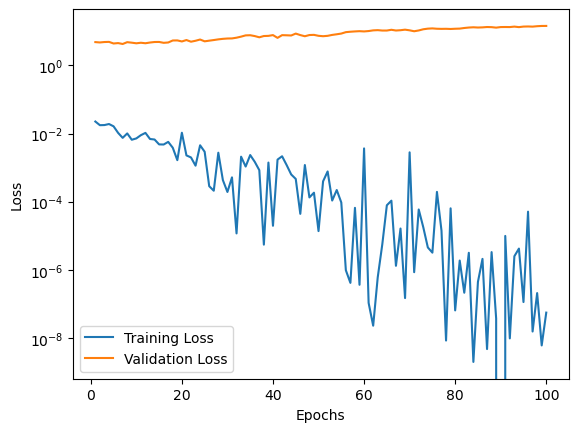

In [ ]:
plt.plot(range(1, 100 + 1), train_losses[:100], label='Training Loss')
plt.plot(range(1, 100 + 1), val_losses[:100], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

# save train and validation losses
import numpy as np	
np.save('train_losses.npy', train_losses)
np.save('val_losses.npy', val_losses)

In [ ]:
model = model.to('cpu')
torch.cuda.empty_cache()


In [ ]:
torch.cuda.empty_cache()
del model

In [ ]:
print(os.listdir(root_dir)[56])

print(len(train_loader.dataset))

Glioblastoma, IDH-wildtype
752


In [ ]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath):
    model = model_class()  # Initialize model
    model.load_state_dict(torch.load(filepath))
    return model

#save_model(model, 'vgg16_finetuned_10_classes.pt')

In [ ]:
model2 = load_model(TumorClassifier, 'models/model_100.pt')


RuntimeError: Error(s) in loading state_dict for TumorClassifier:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 
	Unexpected key(s) in state_dict: "features.0.weight", "features.0.bias", "features.2.weight", "features.2.bias", "features.5.weight", "features.5.bias", "features.7.weight", "features.7.bias", "features.10.weight", "features.10.bias", "features.12.weight", "features.12.bias", "features.14.weight", "features.14.bias", "features.17.weight", "features.17.bias", "features.19.weight", "features.19.bias", "features.21.weight", "features.21.bias", "features.24.weight", "features.24.bias", "features.26.weight", "features.26.bias", "features.28.weight", "features.28.bias", "pre_logits.fc1.weight", "pre_logits.fc1.bias", "pre_logits.fc2.weight", "pre_logits.fc2.bias", "head.fc.weight", "head.fc.bias", "classifier.1.weight", "classifier.1.bias". 

tensor([[ -48.1789,  -97.1624, -104.7493,  ..., -121.8335, -129.5344,
         -140.0336],
        [ -82.0410,  -99.5186, -108.6781,  ..., -140.0476, -146.7836,
         -152.0998],
        [-188.4412, -157.0849, -175.3475,  ..., -275.6000, -276.0184,
         -245.9877],
        [ -83.8879, -101.7352, -111.8788,  ..., -208.9707, -192.4358,
         -225.1004]])
Correct Predictions:


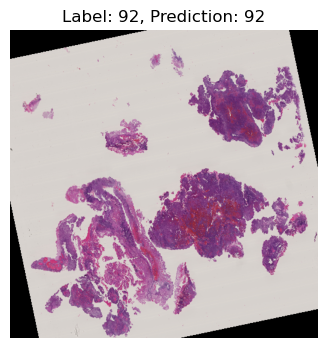

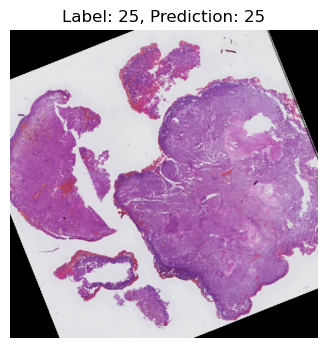

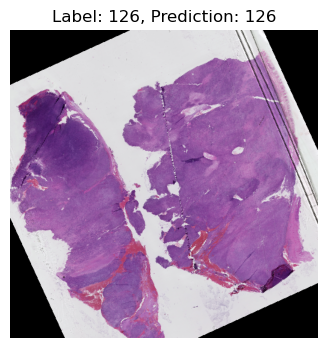

Incorrect Predictions:


IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt

model = model.to('cpu')

def plot_images(image, label, pred):
    plt.figure(figsize=(4, 4))
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    plt.imshow(image.numpy())
    plt.title(f'Label: {label}, Prediction: {pred}')
    plt.axis('off')
    plt.show()

def visualize_predictions(model, loader):
    model.eval()
    correct_imgs = []
    correct_labels = []
    correct_preds = []
    
    incorrect_imgs = []
    incorrect_labels = []
    incorrect_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            print(outputs)
            for i in range(len(labels)):
                if preds[i] == labels[i] and len(correct_imgs) < 3:
                    correct_imgs.append(images[i])
                    correct_labels.append(labels[i])
                    correct_preds.append(preds[i])
                elif preds[i] != labels[i] and len(incorrect_imgs) < 3:
                    incorrect_imgs.append(images[i])
                    incorrect_labels.append(labels[i])
                    incorrect_preds.append(preds[i])

            if len(correct_imgs) >= 3 or len(incorrect_imgs) >= 3:
                break

    print("Correct Predictions:")
    for i in range(3):
        plot_images(correct_imgs[i], correct_labels[i], correct_preds[i])

    print("Incorrect Predictions:")
    for i in range(3):
        plot_images(incorrect_imgs[i], incorrect_labels[i], incorrect_preds[i])

# Assume `model` is your trained model and `loader` is your validation dataloader
visualize_predictions(model, train_loader)
